<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [53]:
# Set your student number
student_number = 400101861
Name = 'ahmadreza'
Last_Name = 'majlesara'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [54]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

You should consider upgrading via the 'c:\users\digi max\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\digi max\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\digi max\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\digi max\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


## Importing Libraries

In [55]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import random
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [56]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())
X_train, y_train = train_set.data, train_set.targets


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [57]:
num_classes = len(train_set.classes)
print("Number of classes:", num_classes)

# Input dimensions
sample_img, _ = train_set[0]
input_dim = sample_img.shape[1] * sample_img.shape[2]
print("Total number of pixels per image:", input_dim)

Number of classes: 10
Total number of pixels per image: 784


In [58]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

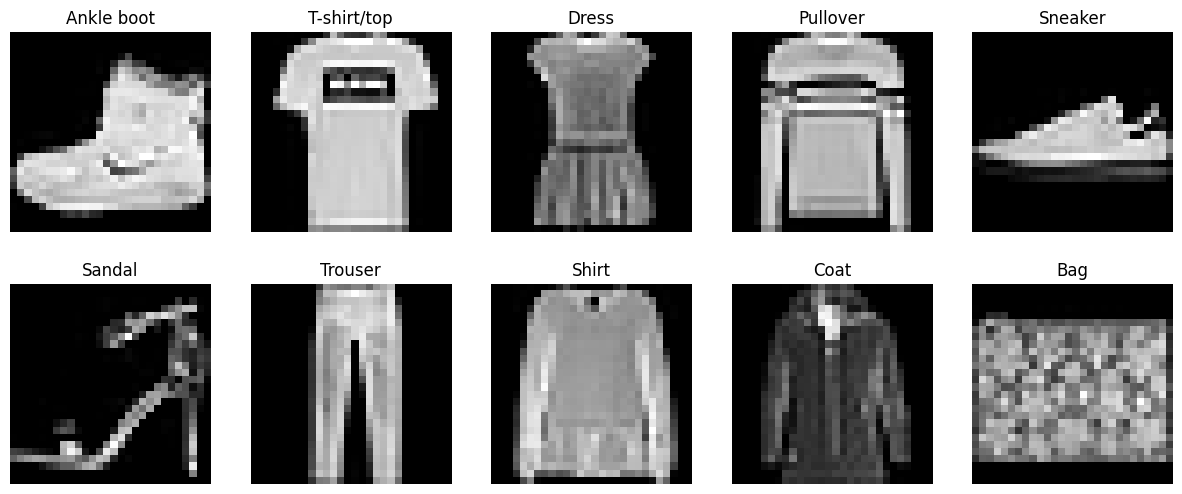

In [59]:
class_images = {}

for idx in range(len(train_set)):
    _, label = train_set[idx]
    if label not in class_images:
        class_images[label] = idx
    if len(class_images) == 10:
        break

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (label, index) in enumerate(class_images.items()):
    image, _ = train_set[index]
    ax = axes[i//5, i%5]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(train_set.classes[label])
    ax.axis('off')

plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [60]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [61]:
# input_dim : input dimention of the first layer, which you have calculated before.
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [62]:
def affine_forward(x, w, b):
    return x @ w + b


def relu(x):
    return torch.maximum(x, torch.zeros_like(x))


Function `model` returns output of the whole model for the input `x` using the parameters:

In [63]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    B = x.shape[0]
    x = x.view(B, -1)
    
    for i in range(num_layers):
        w = parameters[f'w{i}']
        b = parameters[f'b{i}']
        
        x = affine_forward(x, w, b)
        
        if i < num_layers - 1:
            x = relu(x)
    
    output = x
    return output


Implementing cross entropy loss:

In [64]:
def cross_entropy_loss(scores, y):
    n = len(y)
    exp_scores = torch.exp(scores - torch.max(scores, 1, keepdim=True)[0])
    probabilities = exp_scores / exp_scores.sum(dim=1, keepdim=True)
    correct_probabilities = probabilities[range(n), y]
    log_probs = -torch.log(correct_probabilities)
    loss = log_probs.mean()
    
    return loss


Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [65]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    for param_key in parameters:
        param = parameters[param_key]
        
        if param.grad is not None:
            param.data -= learning_rate * param.grad.data
        
        param.grad.zero_()

Training functions:

In [66]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    correct_predictions = np.sum(y_pred == y_true)
    acc = correct_predictions / len(y_true)
    return acc

def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using backward method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)
    
    Y = []
    Y_pred = []
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)
        loss = cross_entropy_loss(p, y)
        train_loss += loss.item()
        for param in parameters.values():
            if param.grad is not None:
                param.grad.zero_()
        loss.backward()
        sgd_optimizer(parameters, learning_rate)
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    average_loss = train_loss / N_train
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Epoch {epoch}: Average Loss = {average_loss:.4f}, Accuracy of train set: {acc:.4f}')

    return average_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch
    
    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)
        loss = cross_entropy_loss(p, y)
        total_loss += loss.item()
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    average_loss = total_loss / N
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Epoch {epoch}: Average {set_name} Loss = {average_loss:.4f}, Accuracy of {set_name} set: {acc:.4f}')

    return average_loss, acc

In [67]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [68]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, learning_rate, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        test_loss, test_acc = validate(test_loader, epoch, 'test')
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    torch.save(parameters, f'{model_name}.pth')

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True,"both")
    plt.minorticks_on()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True,"both")
    plt.minorticks_on()
    plt.legend()

    plt.show()

Epoch 0: Average Loss = 0.0358, Accuracy of train set: 0.3806
Epoch 0: Average test Loss = 0.0355, Accuracy of test set: 0.5265
Epoch 1/25 - Train Loss: 0.0358, Train Acc: 0.3806, Test Loss: 0.0355, Test Acc: 0.5265
Epoch 1: Average Loss = 0.0320, Accuracy of train set: 0.4207
Epoch 1: Average test Loss = 0.0246, Accuracy of test set: 0.4680
Epoch 2/25 - Train Loss: 0.0320, Train Acc: 0.4207, Test Loss: 0.0246, Test Acc: 0.4680
Epoch 2: Average Loss = 0.0191, Accuracy of train set: 0.5235
Epoch 2: Average test Loss = 0.0165, Accuracy of test set: 0.6408
Epoch 3/25 - Train Loss: 0.0191, Train Acc: 0.5235, Test Loss: 0.0165, Test Acc: 0.6408
Epoch 3: Average Loss = 0.0143, Accuracy of train set: 0.6576
Epoch 3: Average test Loss = 0.0133, Accuracy of test set: 0.6883
Epoch 4/25 - Train Loss: 0.0143, Train Acc: 0.6576, Test Loss: 0.0133, Test Acc: 0.6883
Epoch 4: Average Loss = 0.0124, Accuracy of train set: 0.7123
Epoch 4: Average test Loss = 0.0123, Accuracy of test set: 0.7219
Epoch 5/

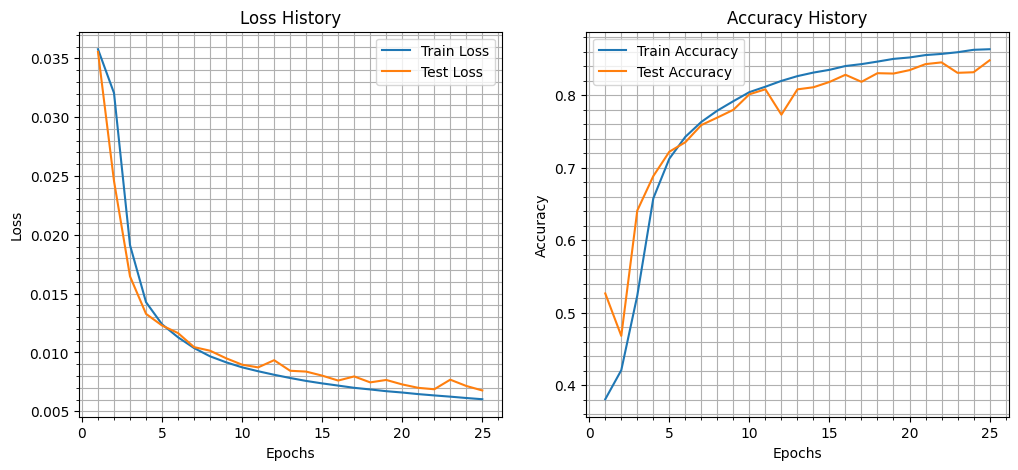

In [69]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [70]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8479


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

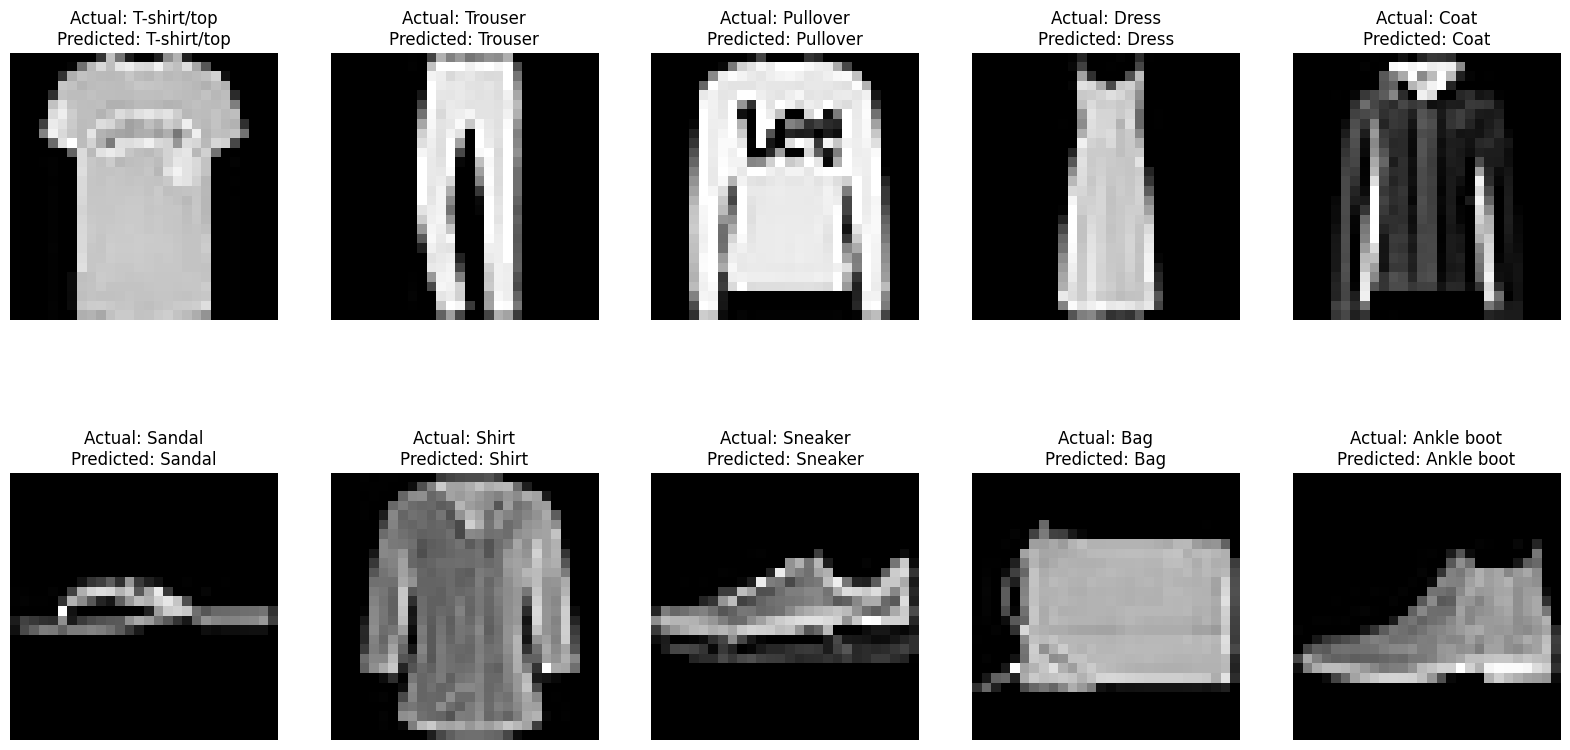

In [71]:
def get_class_images(test_set, num_classes):
    return {i: test_set[np.where(test_set.targets == i)[0][0]][0] for i in range(num_classes)}

def get_class_predictions(model, device, parameters, class_images):
    class_images_tensor = torch.stack(list(class_images.values()))
    with torch.no_grad():
        return model(class_images_tensor.to(device), parameters)

def plot_class_images(class_images, predicted_labels, test_set, num_classes):
    plt.figure(figsize=(20, 10))
    for i in range(num_classes):
        plt.subplot(2, 5, i + 1)
        plt.imshow(class_images[i].permute(1, 2, 0), cmap='gray')
        plt.title(f"Actual: {test_set.classes[i]}\nPredicted: {test_set.classes[predicted_labels[i]]}")
        plt.axis('off')
    plt.show()

class_images = get_class_images(test_set, num_classes)
class_predictions = get_class_predictions(model, device, parameters, class_images)
predicted_labels = torch.argmax(class_predictions, dim=1).cpu().numpy()

plot_class_images(class_images, predicted_labels, test_set, num_classes)